# Notebook Objective

The aim of this notebook is to analyze feature importance by using principal component analysis and the number of principal components that would sufficnently preserve the majority of the information in the data, using variance explained as a measure.

In [1]:
# Import libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# To work with numpy arrays
import numpy as np
# ML model building, training and testing
import sklearn
# Liner regression model building
from sklearn.linear_model import LinearRegression
# Polynomial regression
from sklearn.preprocessing import PolynomialFeatures
# sklearn included transformer
from sklearn.preprocessing import QuantileTransformer
# to split data into test and train
from sklearn.model_selection import train_test_split
# Scaling transform for PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# To run PCA feature reduction
from sklearn.decomposition import PCA
# XGBoost model
from xgboost import XGBRegressor,XGBClassifier
# Random forest regressor
from sklearn.ensemble import RandomForestRegressor
# for regression error calculation
from sklearn.metrics import mean_absolute_error
# for regression r2 score calculation
from sklearn.metrics import r2_score
# for regression mse score calculation
from sklearn.metrics import mean_squared_error
# For hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# To transform the target variable into a normal distribution
from sklearn.compose import TransformedTargetRegressor

## Data Loading

In [3]:
#import csv file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
barstow2017 = pd.read_csv('/content/drive/barstow_2017.csv')

In [4]:
barstow2017

,X,Y,aspect,slope,NDVI,MNDWI,SR_B4,SR_B7,SR_B6,SAVI,ST_B10,NDMI,SR_B3,EVI,MSAVI,MSI,SR_B2,SR_B5,smi
0,478350.0,3845070.0,340,2,0.389658,-0.379756,0.155328,0.221822,0.299345,0.294846,311.079090,0.083173,0.134565,0.302484,0.277401,0.846426,0.086193,0.353658,0.198108
1,478380.0,3845070.0,350,2,0.334047,-0.359627,0.168692,0.231310,0.302287,0.252183,311.038074,0.055669,0.142375,0.253876,0.234891,0.894534,0.091143,0.337927,0.194729
2,478410.0,3845070.0,358,2,0.293744,-0.356553,0.169462,0.233648,0.297613,0.215787,311.014148,0.021076,0.141165,0.214680,0.198167,0.958718,0.091417,0.310428,0.194825
3,478440.0,3845070.0,0,2,0.326162,-0.374574,0.168197,0.237278,0.308200,0.244431,311.003894,0.035707,0.140230,0.244199,0.226916,0.931048,0.089768,0.331025,0.195598
4,478470.0,3845070.0,345,1,0.355590,-0.379177,0.167400,0.237003,0.314580,0.271805,311.000476,0.056343,0.141605,0.273777,0.254934,0.893325,0.089272,0.352145,0.197915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853539,517470.0,3881820.0,103,1,0.174625,-0.288575,0.211152,0.271130,0.317550,0.132478,314.018588,-0.027587,0.175320,0.135786,0.120717,1.056739,0.122987,0.300500,0.159104
1853540,517500.0,3881820.0,101,1,0.186961,-0.295401,0.205515,0.264943,0.312820,0.140994,314.059604,-0.020866,0.170150,0.143882,0.128455,1.042620,0.118780,0.300032,0.157559
1853541,517530.0,3881820.0,101,1,0.183992,-0.284497,0.207825,0.266317,0.313260,0.139275,314.011752,-0.019055,0.174495,0.143433,0.126983,1.038850,0.121997,0.301545,0.157849
1853542,517560.0,3881820.0,102,1,0.184885,-0.284691,0.208595,0.267720,0.313343,0.140283,314.008334,-0.016414,0.174467,0.143382,0.128010,1.033375,0.120650,0.303223,0.155822


In [5]:
# Taking a random sample from the dataset to reduce size (for runtime and plotting)
barstow2017 = barstow2017.sample(n = 500, random_state = 42)

## PCA Analysis for feature importance

In [6]:
X = barstow2017.drop('smi',1)
y = barstow2017['smi']

<ipython-input-6-798c2ffe3b12>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = barstow2017.drop('smi',1)


In [7]:
# Dropping some features X, Y, SRB2, SRB3, SRB4 (similar to the paper) and MSI
# X = X[['aspect','slope','NDMI','SR_B5','SAVI','EVI','NDVI','ST_B10'
#                                  ,'MNDWI','SR_B7','SR_B6','MSAVI', 'MSI']]
X = X[['aspect','slope','NDMI','SR_B5','SAVI','EVI','NDVI','ST_B10'
                                  ,'MNDWI','SR_B7','SR_B6','MSAVI', 'MSI']]

In [7]:
X

,aspect,slope,NDMI,SR_B5,SAVI,EVI,NDVI,ST_B10,MNDWI,SR_B7,SR_B6,MSAVI,MSI
1413410,306,0,-0.075810,0.469350,0.062542,0.067548,0.065355,308.177191,-0.231829,0.495475,0.546350,0.061347,1.164057
1252432,270,2,-0.099771,0.338203,0.140218,0.142373,0.174646,311.725096,-0.348342,0.348102,0.413167,0.130072,1.221657
628215,331,0,-0.129092,0.375877,0.167650,0.178831,0.201050,312.442880,-0.396917,0.445288,0.487308,0.157907,1.296453
473761,328,1,-0.030147,0.296815,0.127656,0.128485,0.168891,311.755858,-0.277460,0.280122,0.315267,0.116103,1.062168
686609,5,1,-0.003187,0.352667,0.198967,0.201291,0.250200,311.790039,-0.352182,0.300252,0.354922,0.185789,1.006394
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204120,290,1,-0.038242,0.359982,0.125695,0.126660,0.150766,311.147451,-0.284629,0.338505,0.388610,0.117743,1.079525
1533818,180,4,0.000423,0.325112,0.218027,0.217525,0.289477,316.342841,-0.395957,0.246298,0.324838,0.201518,0.999154
639459,307,3,-0.033669,0.391085,0.103925,0.109987,0.118836,309.964816,-0.255835,0.363860,0.418337,0.098698,1.069684
605725,284,1,-0.069747,0.381817,0.127623,0.127030,0.149097,311.260245,-0.327837,0.390315,0.439072,0.120610,1.149954


In [8]:
# Recommended to run PCA after scaling features so that variance is calculated and compared equally between features
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [9]:
# Creating a PCA object named pca.
pca = PCA()
X_new = pca.fit_transform(X_scaled)

In [10]:
# The PCA class contains explained_variance_ratio_ which returns the variance explained by each of the principal components.
print(pca.explained_variance_ratio_) # the percentage of the variance

[4.77469059e-01 2.42464799e-01 9.18415123e-02 7.57943805e-02
 6.06612876e-02 4.26546662e-02 5.38167488e-03 1.98818718e-03
 9.88884911e-04 4.15012354e-04 1.79948150e-04 1.37228773e-04
 2.33592435e-05]


In [58]:
# calculating the variance explained (indication of variable importance) from PCA and displaying as a sorted dataframe
pct_variance_explained_dict = {}
col_names = X.columns
for i in range(len(col_names)):
  pct_variance_explained_dict [col_names[i]] = pca.explained_variance_ratio_[i]
var_explained_df = pd.DataFrame.from_dict(pct_variance_explained_dict,orient='index', columns = ['pct_variance_explained'])
var_explained_df['pct_variance_explained'] = var_explained_df['pct_variance_explained']*100
var_explained_df = var_explained_df.sort_values('pct_variance_explained').reset_index()
var_explained_df

,index,pct_variance_explained
0,MSI,0.002336
1,MSAVI,0.013723
2,SR_B6,0.017995
3,SR_B7,0.041501
4,MNDWI,0.098888
5,ST_B10,0.198819
6,NDVI,0.538167
7,EVI,4.265467
8,SAVI,6.066129
9,SR_B5,7.579438


Text(0.5, 0.98, 'Variable variance explained')

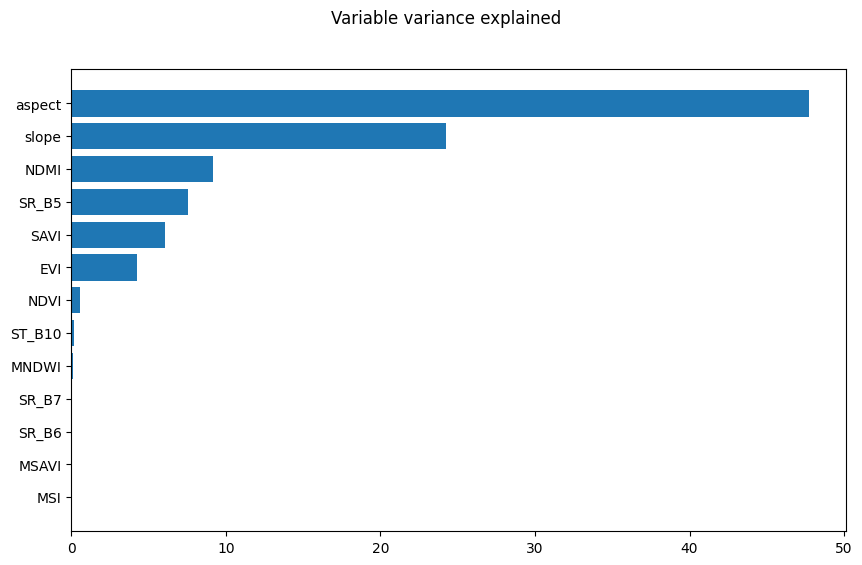

In [59]:
variables = list(var_explained_df['index'])
variance_exp = list(var_explained_df['pct_variance_explained'])
fig, axs = plt.subplots(figsize=(10, 6))
ax.invert_yaxis()
axs.barh(variables, variance_exp)
fig.suptitle('Variable variance explained')


<ipython-input-40-293fbbdb67c7>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_barstow2017, dtype=np.bool))


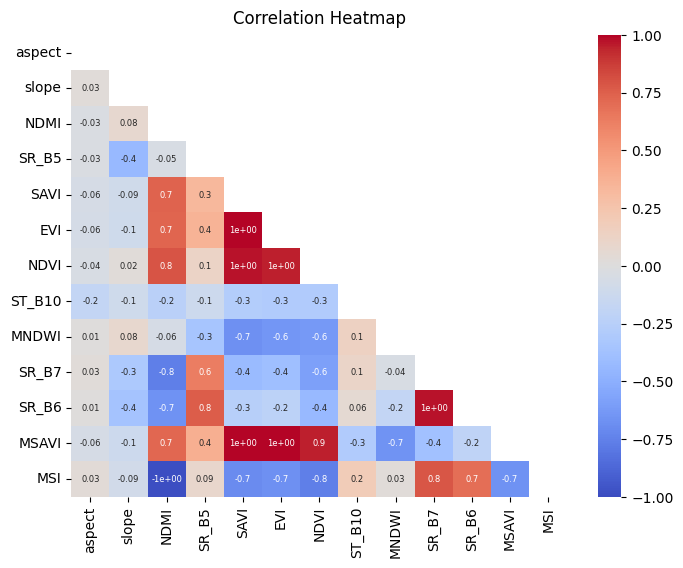

In [40]:
# Looking at collinearity among features
#from https://sinanthahir.medium.com/experience-analysis-through-weather-data-exploratory-data-analysis-b438ceca8a9b
# https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

#features organized by land surface features
features = list(X.columns)

# assign data correlation matrix
corr_barstow2017 = barstow2017[features].corr()
#create a figure to view corr
plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(corr_barstow2017, dtype=np.bool))
heatmap = sns.heatmap(corr_barstow2017, vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":6},  fmt=".1", cmap='coolwarm', cbar=True, center=0.00, mask=mask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=8);

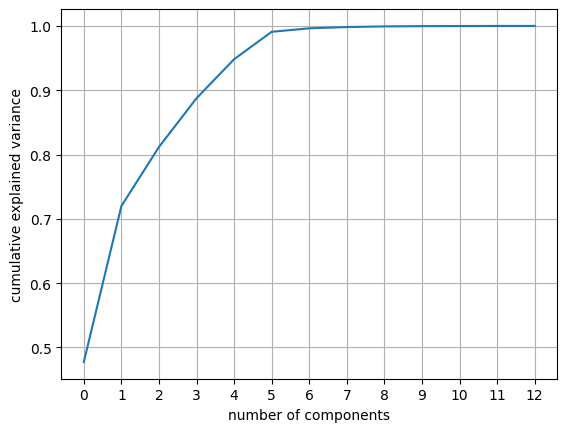

In [13]:
# To better understand the importance of the derived principal components, we can plot the variance per feature and observe the leaerning curve
PCA_fit = PCA().fit(X_scaled)
plt.plot(np.cumsum(PCA_fit.explained_variance_ratio_))
plt.xlabel('number of components')
plt.xticks(np.arange(0, 13, 1.0))
plt.ylabel('cumulative explained variance')
plt.grid();

From the plot above, we can see number of principal components to achieve maximum learning value from the dimentionality reduction.
The dataframe **var_explained_df** shown previously lists the variables in descending order in terms of variance explained (importance)

### Plotting Each Component vs. Original Data (The plot below works better with less features) reduce the number of features and rerun
The next step is to visualize the data resulting from each component. We will use the inverse_transform method of the PCA model, and this will take each of the components and transform them back into the original data scale. We will plot the entire range of components from 1-6 and overlay them with the original data.

In [16]:
# From https://www.dataknowsall.com/pcavisualized.html
def transform_pca(X, n):

    pca = PCA(n_components=n)
    pca.fit(X)
    X_new = pca.inverse_transform(pca.transform(X))

    return X_new

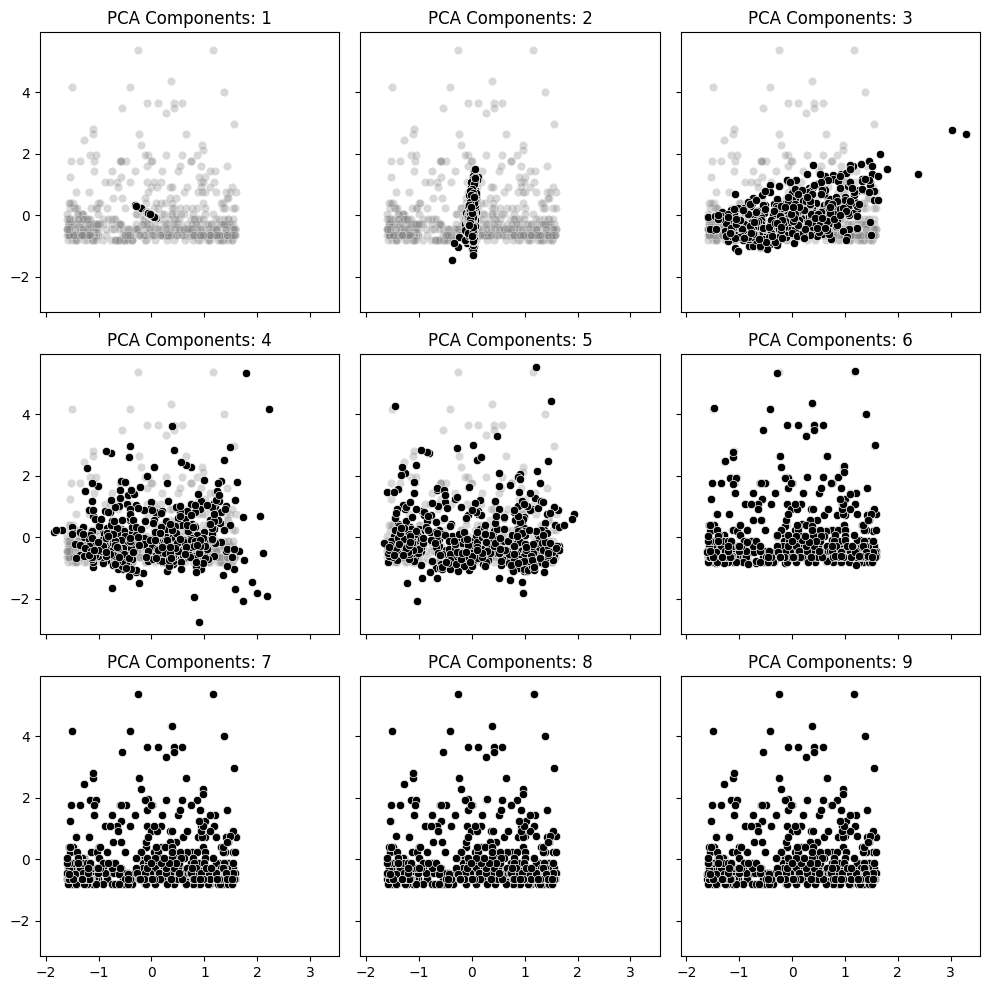

In [17]:
rows = 3
cols = 3
comps = 1

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

fig, axes = plt.subplots(rows,
                         cols,
                         figsize=(10,10),
                         sharex=True,
                         sharey=True)


for row in range(rows):
    for col in range(cols):
        try:
            X_new = transform_pca(X_scaled, comps)
            ax = sns.scatterplot(x=X_scaled[:, 0],
                                 y=X_scaled[:, 1],
                                 ax=axes[row, col],
                                 color='grey',
                                 alpha=.3)
            ax = sns.scatterplot(x=X_new[:, 0],
                                 y=X_new[:, 1],
                                 ax=axes[row, col],
                                 color='black')
            ax.set_title(f'PCA Components: {comps}');

            comps += 1
        except:
            pass
plt.tight_layout()
# plt.savefig('pcavisualize_2.png', dpi=300)

In the plot, the gray data is the original data, and the black points are the Principal Components. The plot axes are the vectors with the most variance in the original data. In each subplot, data from one additional PC (via reverse PCA transform) is added to the plot (hence the increasing number of black points from subplot to the next).  As more and more components are added, we can see how the data starts to resemble the original data. By the time we get into the higher number of PCs, the data starts to match the original data where finally, at all 6 components, it is the same as the original.

### Finding the contribution of features to the principal components (interpreting the principal components)


In [14]:
# component loadings or weights (correlation coefficient between original variables and the component)
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = PCA_fit.components_
num_pc = PCA_fit.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
variable,,,,,,,,,,,,,
aspect,-0.017574,-0.012089,0.694767,-0.333899,-0.611267,0.173516,0.037734,0.005607,-0.009115,-0.006489,0.002923,0.003219,0.001130
slope,0.018972,-0.289651,0.311172,0.596813,0.218021,0.642838,0.041043,0.004766,-0.003069,-0.012221,-0.005957,-0.007314,-0.000343
NDMI,0.358870,-0.148211,-0.065033,-0.292375,0.110970,0.211350,-0.189332,-0.194531,0.404775,0.573690,-0.309164,0.003452,-0.200758
SR_B5,0.027588,0.509191,-0.025765,-0.232166,0.200103,0.394397,-0.033175,0.459844,0.070763,0.144842,0.492376,-0.061164,-0.071338
SAVI,0.378417,0.179528,-0.022724,0.058603,-0.057080,0.022735,0.125823,-0.004402,-0.167730,-0.314496,-0.198243,-0.527751,-0.596767
EVI,0.373161,0.192358,-0.019219,0.038834,-0.016332,0.030521,0.465527,-0.059406,0.042490,-0.151666,-0.028635,0.737778,-0.174601
NDVI,0.391884,0.070364,0.014796,0.119121,-0.079373,-0.054249,-0.087751,-0.435202,-0.540879,0.353988,0.426018,-0.048536,0.137906
ST_B10,-0.126619,-0.056106,-0.628975,0.078430,-0.630481,0.421499,0.048435,-0.018350,-0.018730,0.027843,0.004186,0.003432,0.007360
MNDWI,-0.191118,-0.336860,-0.087551,-0.530259,0.307756,0.249407,0.509478,-0.167513,-0.317798,-0.044465,0.018573,-0.112823,0.023813


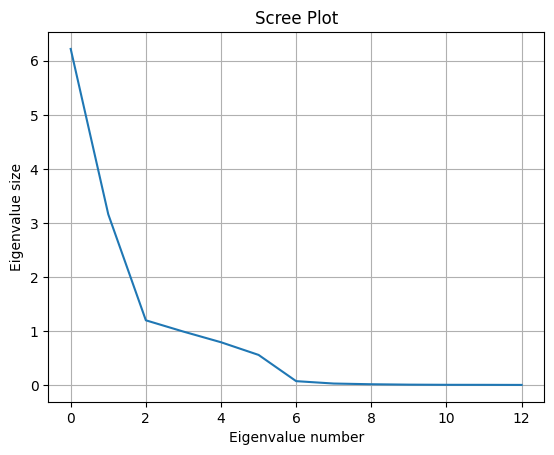

In [17]:
#plt.style.use("ggplot")

eigen_vals = pca.explained_variance_

plt.plot(eigen_vals#, marker='o', color='blue'
         )
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")
plt.grid()

# plt.savefig('scree plot.png')

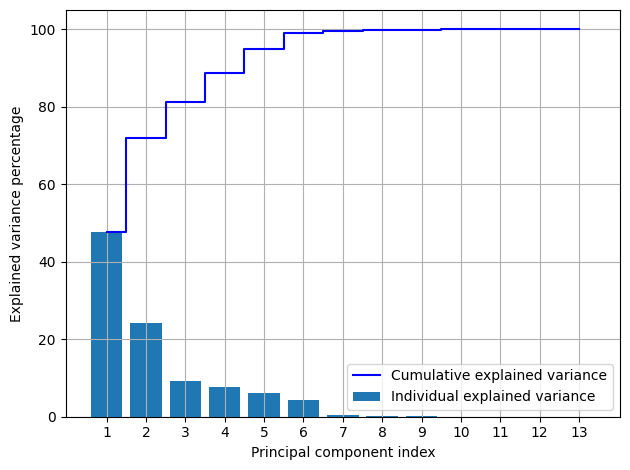

In [19]:
# https://medium.com/data-science-365/2-plots-that-help-me-to-choose-the-right-number-of-principal-components-351a87e15a9f

exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

a = 14 # Number of input features + 1

plt.bar(range(1, a), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, a), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='blue')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, a)))
plt.legend(loc='best')
plt.tight_layout()
plt.grid()

# plt.savefig("cumulative explained variance plot.png")

The above scree plot and variance explained bar chart both show that 6 principal components are sufficient to preserve the information in the variables selected using variance explained as a measure.

The below visualizations explore which variables contribute to the most important principal components

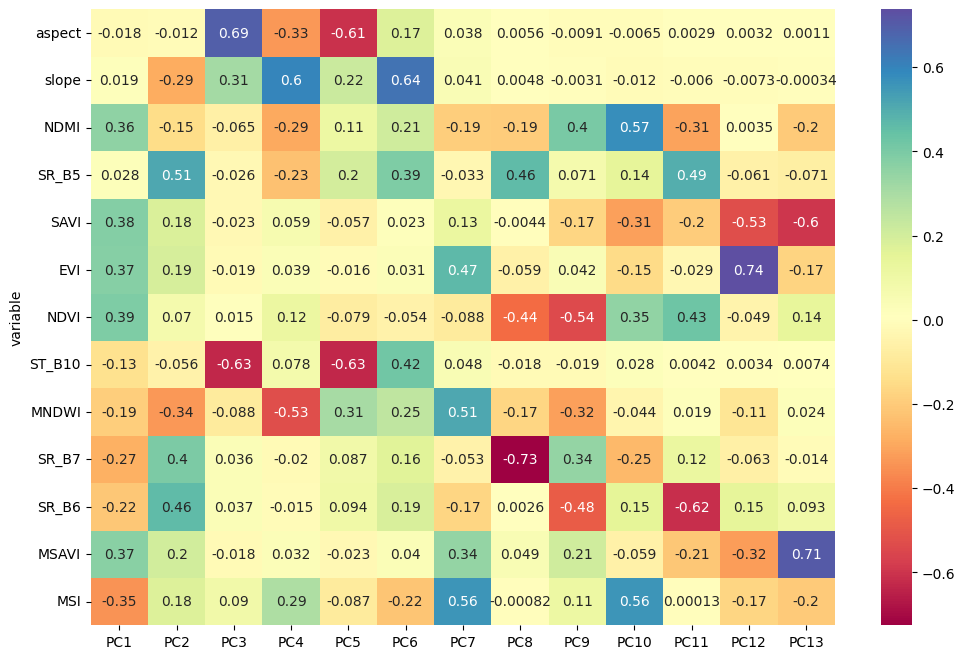

In [20]:
# get correlation matrix plot for loadings
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

The above variable/PC matrix shows that the highest contributing variables to PC1 are NDVI, SAVI, EVI and NDMI. The highest contributing variables to PC2 are SR_B5, SR_B6, and SR_B7.

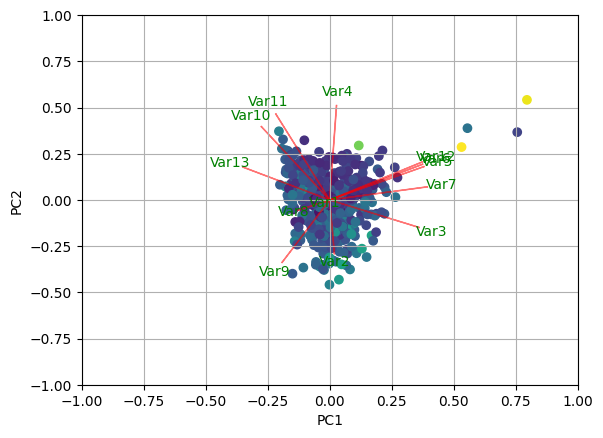

In [21]:
# get 2D biplot

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(
        xs * scalex
        , ys * scaley
        , c = y
        )
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(X_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [22]:
# get eigenvalues (variance explained by each PC)
PCA_fit.explained_variance_

array([6.21953684e+00, 3.15835911e+00, 1.19633232e+00, 9.87301550e-01,
       7.90177093e-01, 5.55621905e-01, 7.01019774e-02, 2.58982298e-02,
       1.28812664e-02, 5.40597255e-03, 2.34401397e-03, 1.78754915e-03,
       3.04278723e-04])

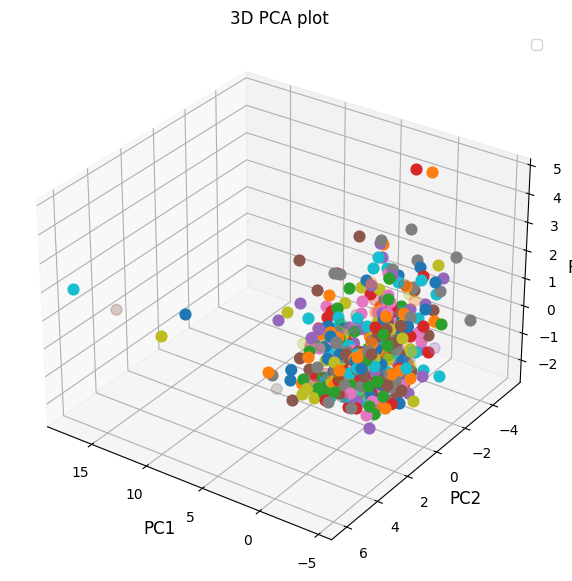

In [23]:
# 3D
# https://statisticsglobe.com/3d-plot-pca-python
# Each axis represents one of the first three components

#cdict = {0:'m',1:'c'} #classes for classification problem
#label = {0:'Malignant',1:'Benign'} #classes for classification problem


Xax = X_new[:,0]
Yax = X_new[:,1]
Zax = X_new[:,2]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111,
                     projection='3d')

for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix],
            Yax[ix],
            Zax[ix],
            #c=cdict[l],
            s=60,
           #label=label[l]
            )

ax.set_xlabel("PC1",
              fontsize=12)
ax.set_ylabel("PC2",
              fontsize=12)
ax.set_zlabel("PC3",
              fontsize=12)

ax.view_init(30, 125)
ax.legend()
plt.title("3D PCA plot")
plt.show()

Training a simple XGB model to analyze feature importance

In [24]:
#Splitting the data into test (25%) and train (75%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
features = ['aspect','slope','NDMI','SR_B5','SAVI','EVI','NDVI','ST_B10'
                                 ,'MNDWI','SR_B7','SR_B6','MSAVI']

In [26]:
# Defining a function to train and test models
def train_test_model(df, reg, features, scale = False, test_size= 0.25, n_pca = None):
  # takes as an input df: dataframe with all independent variables and the output variable. Output variable must be the last column.
  #                   reg: model constructor, example: reg = LinearRegression()
  #                   features: series of features from the dataset to be used for train/test, compute this using X.columns
  #                   scale = Option to scale features prior to training, default = False
  #                   test_size = float, percentage of data to be used for testing. Default = 0.25 (25%)
  #                   n_pca = int, number of principal components to reduce the independent varibles to. Default = None (no pca is done). Recommended to use scale = True if using pca.
  print(type(reg).__name__)

  X = df.iloc[:,:-1] # Select all independent variables as X
  y = df.iloc[:,-1]  # Select the last variable in the dataframe as the target variable y

  # Splitting the data into test (25%) and train (75%)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=42)

  # Normalize independent variables (both train and test) if required
  if scale == True:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

  # Run PCA if required. Recommended to normalize if PCA will be used
  if n_pca is not None:
    pca = PCA(n_components= n_pca)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

  # Features into a dataframe
  X_train_df= pd.DataFrame(X_train)
  # Come back to this lower line, should get columns from input variable feature as a list
  #X_train_df.columns=X.columns
  #X_train_df.columns= features
  X_test_df= pd.DataFrame(X_test)
  #X_test_df.columns=X.columns
  #X_test_df.columns= features

  #reg.fit(X_train_df[features],y_train)
  reg.fit(X_train_df,y_train)
  #y_pred_reg = reg.predict(X_test_df[features])
  y_pred_reg = reg.predict(X_test_df)

  results = {}
  r2 = r2_score(y_test, y_pred_reg)
  n = len(y_test)
  k = len(features)
  adj_r2_score = 1-(((1-r2)*(n-1))/(n-k-1))
  mae = mean_absolute_error(y_test,y_pred_reg)
  mse = mean_squared_error(y_test,y_pred_reg)

  print("Features used for model training = ", features)
  print("Number of principal components used for model training = ", n_pca)
  print("MAE = ", mae)
  print("MSE = ", mse)
  print("R2 Score = ", r2 )
  print("Adjusted R2 Score = ", adj_r2_score)

  results['X_train'] = X_train
  results['y_train'] = y_train
  results['X_test'] = X_test
  results['y_test'] = y_test
  results['y_pred_reg'] = y_pred_reg
  results['MAE'] = mae
  results['MSE'] = mse
  results['R2 Score'] = r2
  results['Adjusted R2 Score'] = adj_r2_score
  results['name'] = type(reg).__name__

  return results

In [27]:
# XGBoost Regression no parameters (alternative tree based algorithm)
# max_depth = 3 takes 14 sec to run
xgb_reg = XGBRegressor(max_depth=12)
xgb_reg_results = train_test_model(barstow2017, xgb_reg, features = features, scale = False, test_size= 0.25, n_pca = None)

XGBRegressor
Features used for model training =  ['aspect', 'slope', 'NDMI', 'SR_B5', 'SAVI', 'EVI', 'NDVI', 'ST_B10', 'MNDWI', 'SR_B7', 'SR_B6', 'MSAVI']
Number of principal components used for model training =  None
MAE =  0.03147696632274589
MSE =  0.0017286311203975429
R2 Score =  0.693501960572547
Adjusted R2 Score =  0.6606628849196056


<Axes: >

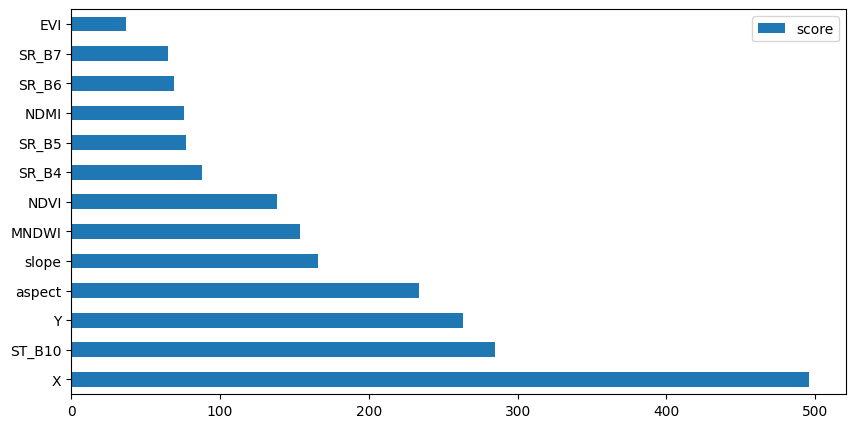

In [50]:
# ‘weight’ - the number of times a feature is used to split the data across all trees.
# ‘gain’ - the average gain across all splits the feature is used in.
# ‘cover’ - the average coverage across all splits the feature is used in.
# ‘total_gain’ - the total gain across all splits the feature is used in.
# ‘total_cover’ - the total coverage across all splits the feature is used in.
feature_importance = xgb_reg.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(13, columns="score").plot(kind='barh', figsize = (10,5)) ## plot top 13 features

<Axes: >

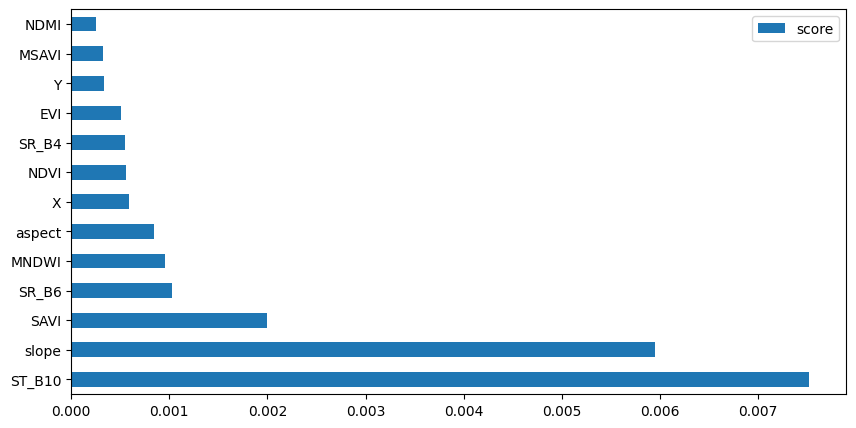

In [35]:
feature_importance = xgb_reg.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(13, columns="score").plot(kind='barh', figsize = (10,5)) ## plot top 13 features

<Axes: >

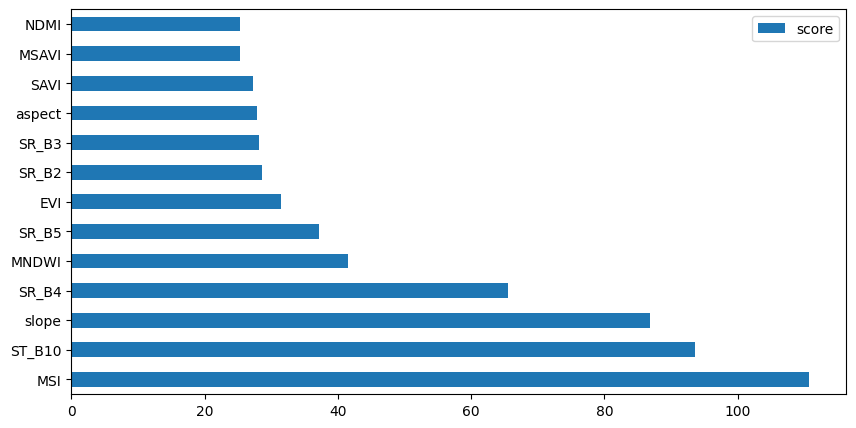

In [36]:
feature_importance = xgb_reg.get_booster().get_score(importance_type='cover')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(13, columns="score").plot(kind='barh', figsize = (10,5)) ## plot top 13 features

<Axes: >

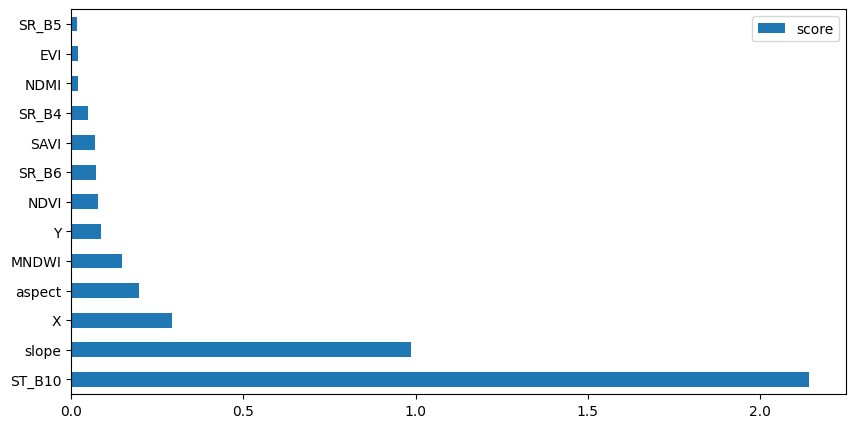

In [37]:
feature_importance = xgb_reg.get_booster().get_score(importance_type='total_gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(13, columns="score").plot(kind='barh', figsize = (10,5)) ## plot top 13 features

<Axes: >

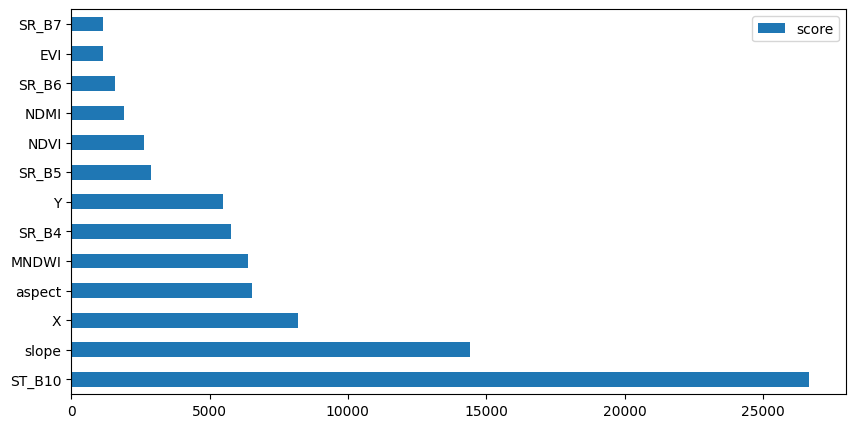

In [38]:
feature_importance = xgb_reg.get_booster().get_score(importance_type='total_cover')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(13, columns="score").plot(kind='barh', figsize = (10,5)) ## plot top 13 features